<b>决策树</b><br/>
<b>优点：</b>计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据。<br/>
<b>缺点：</b>可能会产生过度匹配问题。<br/>
<b>适用数据类型：</b>数值型和标称型

什么是<b>信息增益</b>呢？在划分数据集之前之后信息发生的变化成为信息增益，知道如何计算信息增益，我们就可以计算每个特征值划分数据集获得的信息增益，获得信息增益最高的特征就是最好的选择。

 在可以评测哪个数据划分方式是最好的数据划分之前，我们必须学习如何计算信息增益。集合信息的度量方式成为<b>香农熵或者简称为熵(entropy)</b>，这个名字来源于信息论之父克劳德·香农。
 
熵定义为信息的期望值。在信息论与概率统计中，熵是表示随机变量不确定性的度量。熵越大，随机变量的不确定性就越大。

In [1]:
from math import log

In [2]:
#计算给定数据集的香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): 
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt

In [3]:
#验证香农熵
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet,labels

In [4]:
calcShannonEnt(createDataSet()[0])

0.9709505944546686

In [5]:
#按照给定特征划分数据集  待划分的数据集、划分数据集的特征、特征的返回值
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [6]:
#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    a = {}
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        a[i] = infoGain
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature,a                    #returns an integer

In [7]:
chooseBestFeatureToSplit(createDataSet()[0])

(0, {0: 0.4199730940219749, 1: 0.17095059445466854})

In [8]:
#采用多数表决的方法，决定该叶子节点的分类
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.itema(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [9]:
#创建树的函数   数据集、标签列表
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)[0]
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

In [10]:
tree = createTree(createDataSet()[0],createDataSet()[1])
print(tree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [11]:
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [12]:
#获取决策树叶子结点的数目
def getNumLeafs(myTree):
    numLeafs = 0                                                #初始化叶子
    firstStr = next(iter(myTree))                                #python3中myTree.keys()返回的是dict_keys,不在是list,所以不能使用myTree.keys()[0]的方法获取结点属性，可以使用list(myTree.keys())[0]
    secondDict = myTree[firstStr]                                #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':                #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

In [13]:
#获取决策树的层数
def getTreeDepth(myTree):
    maxDepth = 0                                                #初始化决策树深度
    firstStr = next(iter(myTree))                                #python3中myTree.keys()返回的是dict_keys,不在是list,所以不能使用myTree.keys()[0]的方法获取结点属性，可以使用list(myTree.keys())[0]
    secondDict = myTree[firstStr]                                #获取下一个字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':                #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth            #更新层数
    return maxDepth

In [14]:
#绘制节点 使用文本注解绘制树节点
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")                      #设置中文字体
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',    #绘制结点
        xytext=centerPt, textcoords='axes fraction',
        va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

In [15]:
#标注有向边属性值
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]                                            #计算标注位置                   
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [16]:
#绘制决策树
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")                                        #设置结点格式
    leafNode = dict(boxstyle="round4", fc="0.8")                                            #设置叶结点格式
    numLeafs = getNumLeafs(myTree)                                                          #获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree)                                                            #获取决策树层数
    firstStr = next(iter(myTree))                                                            #下个字典                                                 
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)    #中心位置
    plotMidText(cntrPt, parentPt, nodeTxt)                                                    #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)                                        #绘制结点
    secondDict = myTree[firstStr]                                                            #下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD                                        #y偏移
    for key in secondDict.keys():                               
        if type(secondDict[key]).__name__=='dict':                                            #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            plotTree(secondDict[key],cntrPt,str(key))                                        #不是叶结点，递归调用继续绘制
        else:                                                                                #如果是叶结点，绘制叶结点，并标注有向边属性值                                             
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [17]:
#创建绘制面板
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')                                                    #创建fig
    fig.clf()                                                                                #清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)                                #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))                                            #获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))                                            #获取决策树层数
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;                                #x偏移
    plotTree(inTree, (0.5,1.0), '')                                                            #绘制决策树
    plt.show()  

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}} ['flippers']


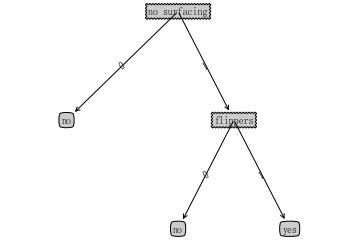

In [18]:
dataSet, labels = createDataSet()
myTree = createTree(dataSet, labels)
print(myTree,labels)  
createPlot(myTree)

In [19]:
#使用决策树的分类函数  已经生成的决策树、存储选择的最优特征标签、测试数据列表，顺序对应最优特征标签
def classify(inputTree,featLabels,testVec):
    firstStr = next(iter(inputTree.keys()))
    print(featLabels)
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: 
        classLabel = valueOfFeat
    return classLabel

In [20]:
dataSet, labels = createDataSet()
featLabels = labels.copy()
myTree = createTree(dataSet, featLabels)
print(myTree,labels,featLabels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}} ['no surfacing', 'flippers'] ['flippers']


In [21]:
classify(myTree,labels,[1,1])

['no surfacing', 'flippers']
['no surfacing', 'flippers']


'yes'

In [22]:
#采用scikit-learn
from sklearn import tree

In [23]:
clf = tree.DecisionTreeClassifier()

In [24]:
#转换数据格式
X = []
Y = []
for i in dataSet:
    temp_x = []
    for j in i:
        if j == 'yes':
            Y.append(1)  
        elif j == 'no':
            Y.append(0)
        else:
            temp_x.append(j)
    X.append(temp_x)

In [25]:
import numpy as np
X = np.array(X)

In [26]:
clf = clf.fit(X, Y)

In [27]:
predict = clf.predict([[1,1]])
if predict == 1:
    print('yes')
else:
    print('no')

yes


In [28]:
#绘制树
import pydotplus
from IPython.display import Image

In [30]:
import graphviz

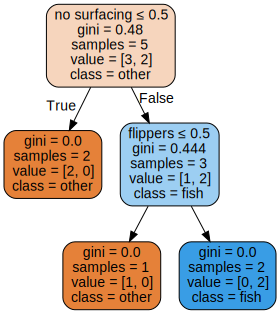

In [35]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Fish")


dot_data = tree.export_graphviz(clf, out_file=None, 
                            feature_names=labels,  
                            class_names=['other','fish'],  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph # doctest: +SKIP

In [33]:
#存储决策树
import pickle
def storeTree(inputTree, filename):
    with open(filename, 'wb') as fw:
        pickle.dump(inputTree, fw)
        

In [39]:
storeTree(myTree,'tree.txt')

In [40]:
#加载树
def grabTree(filename):
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [41]:
grabTree('tree.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [43]:
with open('lenses.txt', 'r') as fr:                                        #加载文件
        lenses = [inst.strip().split('\t') for inst in fr.readlines()]        #处理文件
lenses_target = []                                                        #提取每组数据的类别，保存在列表里
for each in lenses:
    lenses_target.append(each[-1])

In [46]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']            #特征标签

In [47]:
#特征 编码
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [50]:
import pandas as pd

In [78]:
lenses_arr = np.array(lenses)
lenses_pd = pd.DataFrame()
for i in range(len(lensesLabels)):
    lenses_pd[lensesLabels[i]] = le.fit_transform(lenses_arr[:,i])

In [79]:
lenses_pd.head()

,age,prescript,astigmatic,tearRate
0,2,1,0,1
1,2,1,0,0
2,2,1,1,1
3,2,1,1,0
4,2,0,0,1


In [80]:
clf = tree.DecisionTreeClassifier(max_depth=4)

In [81]:
clf = clf.fit(lenses_pd.values.tolist(), lenses_target)

In [82]:
clf.classes_

array(['hard', 'no lenses', 'soft'], dtype='<U9')

In [83]:
clf.feature_importances_

array([0.13986014, 0.13986014, 0.29370629, 0.42657343])

In [85]:
clf.predict([[1,1,1,0]])

array(['hard'], dtype='<U9')

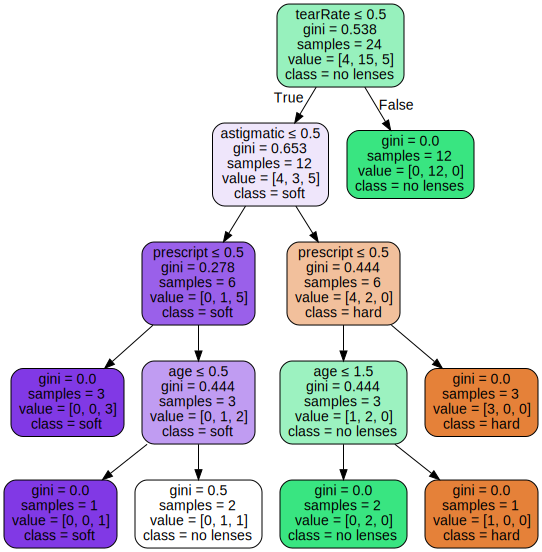

In [86]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Glasses")


dot_data = tree.export_graphviz(clf, out_file=None, 
                            feature_names=lensesLabels,  
                            class_names=clf.classes_,  
                            filled=True, rounded=True,  
                            special_characters=True)  
graph = graphviz.Source(dot_data)  
graph # doctest: +SKIP